# Human Locomotion Challenge - AI Cup 2022

## Introduction

**Context**

The study of human gait is a central problem in medical research with far-reaching consequences in the public health domain.
This complex mechanism can be altered by a wide range of pathologies (such as Parkinson’s disease, arthritis, stroke,...), often resulting in a significant loss of autonomy and an increased risk of fall.
Understanding the influence of such medical disorders on a subject's gait would greatly facilitate early detection and prevention of those possibly harmful situations.
To address these issues, clinical and bio-mechanical researchers have worked to objectively quantify gait characteristics.


Among the gait features that have proved their relevance in a medical context, several are linked to the notion of step (step duration, variation in step length, etc.), which can be seen as the core atom of the locomotion process.
Many algorithms have therefore been developed to automatically (or semi-automatically) detect gait events (such as heel-strikes, heel-off, etc.) from accelerometer/gyrometer signals.

Most of the time, the algorithms used for step detection are dedicated to a specific population (healthy subjects, elderly subjects, Parkinson patients, etc.) and only a few publications deal with heterogeneous populations composed of several types of subjects.
Another limit to existing algorithms is that they often focus on locomotion in established regime (once the subject has initiated its gait) and do not deal with steps during U-turn, gait initiation or gait termination.
Yet, initiation and termination steps are particularly sensitive to pathological states.
For example, the first step of Parkinsonian patients has been described as slower and smaller that the first step of age-matched subjects.
U-turn steps are also interesting since 45% of daily living walking is made up of turning steps, and when compared to straight-line walking, turning has been emphasized as a high-risk fall situation.
This argues for reliable algorithms that could detect initiation, termination and turning steps in both healthy and pathological subjects.


**Step detection**

The objective is to recognize the **start and end times of footsteps** contained in accelerometer and gyrometer signals recorded with Inertial Measurement Units (IMUs).

## Data description

### Participants

The data was collected between April 2014 and October 2015 by monitoring healthy (control) subjects and patients from several medical departments (see [publication](#Publication) for more information).
Participants are divided into three groups depending on their impairment:
- **Healthy** subjects had no known medical impairment.
- The **orthopedic group** is composed of 2 cohorts of distinct pathologies: lower limb osteoarthrosis and cruciate ligament injury.
- The **neurological group** is composed of 4 cohorts: hemispheric stroke, Parkinson's disease, toxic peripheral neuropathy and radiation induced leukoencephalopathy.

Note that certain participants were recorded on multiple occasions, therefore several trials may correspond to the same person.
In the training set and in the testing set, the proportion of trials coming from the "healthy", "orthopedic" and "neurological" groups is roughly the same, 24%, 24% and 52% respectively.

### Protocol and equipment

All subjects underwent the same protocol described below. First, a IMU (Inertial Measurement Unit) that recorded accelerations and angular velocities was attached to each foot.
All signals have been acquired at 100 Hz with two brands of IMUs: XSens&trade; and Technoconcept&reg;.
One brand of IMU was attached to the dorsal face of each foot.
(Both feet wore the same brand.)
After sensor fixation, participants were asked to perform the following sequence of activities:
- stand for 6 s,
- walk 10 m at preferred walking speed on a level surface to a previously shown turn point,
- turn around (without previous specification of a turning side),
- walk back to the starting point,
- stand for 2 s.

Subjects walked at their comfortable speed with their shoes and without walking aid.
This protocol is schematically illustrated in the following figure.


<div style="text-align: center">
<img src="https://raw.githubusercontent.com/ramp-kits/human_locomotion/master/images/protocol-schema.png" width="500px">
</div>


Each IMU records its acceleration and angular velocity in the $(X, Y, Z, V)$ set of axes defined in the following figure.
The $V$ axis is aligned with gravity, while the $X$, $Y$ and $Z$ axes are attached to the sensor.
<div style="text-align: center">
<img src="https://raw.githubusercontent.com/ramp-kits/human_locomotion/master/images/sensor-photo.png" width="500px">
</div>

<div style="text-align: center">
<img src="https://raw.githubusercontent.com/ramp-kits/human_locomotion/master/images/sensor-position.png" width="500px">
</div>

## Step detection in a clinical context

The following schema describes how step detection methods are integrated in a clinical context.
<br/><br/>
<div style="text-align: center">
<img src="https://raw.githubusercontent.com/ramp-kits/human_locomotion/master/images/step-detection-schema.png" width="500px">
</div>

(1) During a trial, sensors send their own acceleration and angular velocity to the physician's computer.

(2) A software on the physician's computer synchronizes the data sent from both sensors and produces two multivariate signals (of same shape), each corresponding to a foot.


A step detection procedure is applied on each signal to produce two lists of footsteps (one per foot/sensor).
The numbers of left footsteps and right footsteps are not necessarily the same.
Indeed, subjects often have a preferred foot to initiate and terminate a walk or a u-turn, resulting in one or more footsteps from this preferred foot.
The starts and ends of footsteps are then used to create meaningful features to characterize the subject's gait.

## Data exploration

To run this notebook, please install the following packages: `loadmydata`, `matplotlib` and `pandas`. They are available through `pip` or `conda`.

### Data loading

The data are divided into a training set `(X_train, y_train)` (+ some metadata) and a testing set `(X_test)` (+ some metadata).

The submission consists in predicting the starts and ends of footsteps on the testing set.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')).split("src")[0])

from src.utils.value_smoothing import smooth
from src.cup_scripts.utils import load_train, load_test
from src.cup_scripts.metric import fscore_step_detection

In [8]:
# This will download the data on the first run
X_train, y_train, metadata_train = load_train()
X_test, metadata_test = load_test()

During a trial, a subject executes the protocol described above.
This produces two multivariates signals (one for each foot/sensor) and for each signal, a number of footsteps have be annotated.
In addition, information (metadata) about the trial and participant are provided.
All three elements (signal, step annotation and metadata) are detailled in this section.

In [9]:
# choosing a signal
ind = 156
signal = X_train[ind]

# taking the labelled steps and the metadata
labelled_steps = y_train[ind]
metadata = metadata_train[ind]

In [10]:
# Uncomment any of the following lines

print(signal)  # pandas array
# print(labelled_steps)  # list of length n_steps
# print(metadata)  # dictionary

            AV        AX        AY  ...        RX        RY        RZ
0    -0.000231 -0.008909 -0.012835  ... -0.349733 -0.732183  1.223952
1    -0.000445 -0.008759 -0.018595  ... -0.273186 -0.852389  0.994483
2     0.002626 -0.006369 -0.012793  ...  0.087433 -1.475309  1.005426
3     0.002957 -0.006794 -0.009799  ... -0.611976 -0.830560  0.568260
4     0.002053 -0.007670 -0.005348  ... -0.218583 -0.688466  1.049143
...        ...       ...       ...  ...       ...       ...       ...
3026 -0.004485 -0.011506  0.012727  ... -0.262300  0.535486  0.437109
3027 -0.004012 -0.010314  0.013867  ... -0.546430  0.437109  0.382507
3028  0.002465 -0.012774  0.013342  ... -0.568260  0.754070  0.131150
3029 -0.004581 -0.011594  0.010124  ... -0.273186  0.371563  0.775899
3030 -0.002887 -0.010256  0.010214  ... -0.611976  0.448053  0.393393

[3031 rows x 8 columns]


### Signal

Each IMU that the participants wore provided $\mathbb{R}^{8}$-valued signals, sampled at 100 Hz.
In this setting, each dimension is defined by the signal type (`A` for acceleration, `R` for angular velocity) and the axis (`X`, `Y`, `Z` or `V`).
For instance, `RX` denotes the angular velocity around the `X`-axis.
Accelerations are given in $m/s^2$ and angular velocities, in $deg/s$.
The signal is available as a `Pandas` dataframe.

Note that this multivariate signal originates from a single sensor (either on the left foot or the right foot). Therefore, each trial produced two signals (one per foot).

,AV,AX,AY,AZ,RV,RX,RY,RZ
0,-0.000231,-0.008909,-0.012835,0.009034,0.654080,-0.349733,-0.732183,1.223952
1,-0.000445,-0.008759,-0.018595,0.010203,0.481446,-0.273186,-0.852389,0.994483
2,0.002626,-0.006369,-0.012793,0.010856,0.548060,0.087433,-1.475309,1.005426
3,0.002957,-0.006794,-0.009799,0.010746,-0.043240,-0.611976,-0.830560,0.568260
4,0.002053,-0.007670,-0.005348,0.009034,0.590695,-0.218583,-0.688466,1.049143


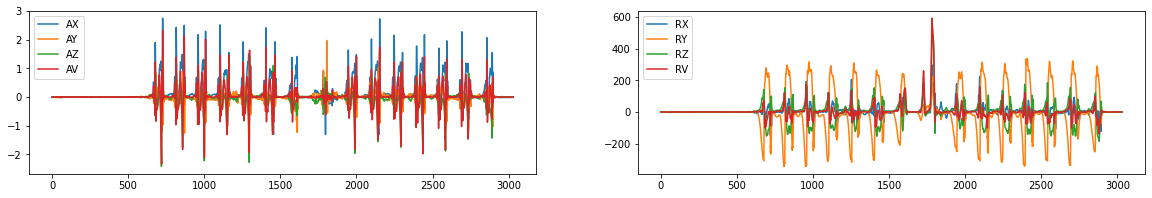

In [11]:
# Plot the signal

fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))

# select the accelerations
signal[["AX", "AY", "AZ", "AV"]].plot(ax=ax_0)

# select the angular velocities
signal[["RX", "RY", "RZ", "RV"]].plot(ax=ax_1)

signal.head()

The "flat part" at the beginning of each dimension is the result of the participants standing still for a few
seconds before walking (see [Protocol](#Protocol-and-equipment)).
The same behaviour can be seen at the end of each dimension (often but not always), though for a quite smaller duration.

###  Metadata
A number of metadata (either numerical or categorical) are provided for each sensor recording, detailing the participant being monitored and the sensor position:

- `Code`: unique identifier for the trial;
- `Age` (in years);
- `Gender`: male ("M") or female ("F");
- `Height` (in meters);
- `Weight` (in kilograms);
- `BMI` (in kg/m2): body mass index;
- `Laterality`: subject's "footedness" or "foot to kick a ball" ("Left", "Right" or "Ambidextrous").
- `Sensor`: brand of the IMU used for the recording (“XSens” or “TCon”);
- `PathologyGroup`: this variable takes value in {“Healthy”, “Orthopedic”, “Neurological”};
- `IsControl`: whether the subject is a control subject ("Yes" or "No");
- `SensorLocation`: foot on which the sensor was attached ("Left" or "Right");
- `WalkedDistance`: distance walked during the trial (in meter);
- `WalkingSpeed`: walking speed during the trial (in m/s).

In [12]:
metadata

{'Subject': 13,
 'Trial': 1,
 'Code': '13-1',
 'Age': 46,
 'Gender': 'F',
 'Height': 1.68,
 'Weight': 57,
 'BMI': 20.2,
 'Laterality': 'Left',
 'Sensor': 'XSens',
 'WalkedDistance': 8.5,
 'WalkingSpeed': 1.5,
 'PathologyGroup': 'Orthopedic',
 'IsControl': 'No',
 'SensorLocation': 'Left'}

### Step annotation (the "label" to predict)
Footsteps were manually annotated by specialists using a software that displayed the signals from the relevant sensor (left or right foot) and allowed the specialist to indicate the starts and ends of each step.

A footstep is defined as the period during which the foot is moving.
Footsteps are separated by periods when the foot is still and flat on the floor.
Therefore, in our setting, a footstep starts with a heel-off and ends with the following toe-strike of the same foot.


Footsteps (the "label" to predict from the signal) are contained in a list whose elements are list of two integers, the start and end indexes. For instance:

In [13]:
labelled_steps

[[657, 734],
 [807, 876],
 [949, 1013],
 [1085, 1168],
 [1244, 1313],
 [1393, 1472],
 [1543, 1620],
 [1705, 1804],
 [1932, 2006],
 [2091, 2156],
 [2233, 2309],
 [2388, 2454],
 [2537, 2600],
 [2678, 2753],
 [2834, 2902]]

Visualization of footsteps and signals:

For the trial '13-1' (left foot), 15 footsteps were annotated.


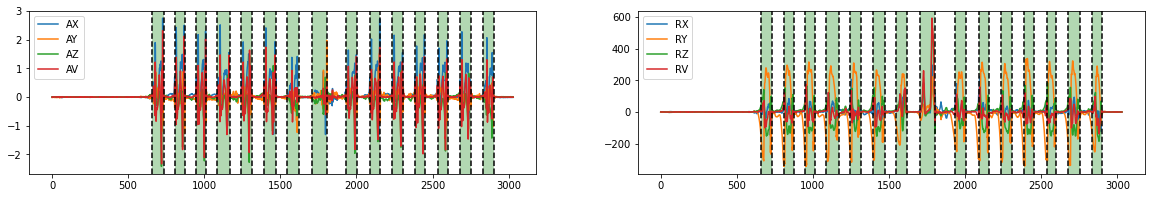

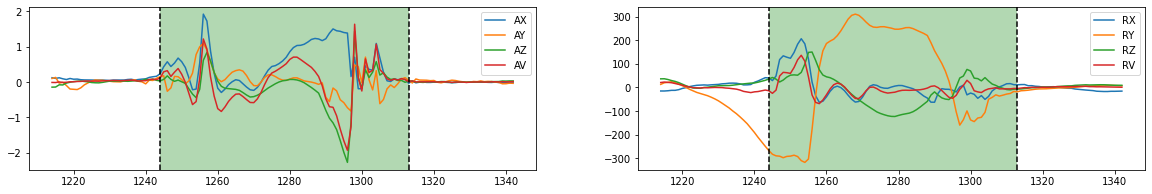

In [14]:
msg = f"For the trial '{metadata['Code']}' ({metadata['SensorLocation'].lower()} foot), {len(labelled_steps)} footsteps were annotated."
print(msg)

# Color the footsteps
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))

ax = ax_0
signal[["AX", "AY", "AZ", "AV"]].plot(ax=ax)
line_args = {"linestyle": "--", "color": "k"}
for (start, end) in labelled_steps:
    ax.axvline(start, **line_args)
    ax.axvline(end, **line_args)
    ax.axvspan(start, end, facecolor="g", alpha=0.3)

ax = ax_1
signal[["RX", "RY", "RZ", "RV"]].plot(ax=ax)
for (start, end) in labelled_steps:
    ax.axvline(start, **line_args)
    ax.axvline(end, **line_args)
    ax.axvspan(start, end, facecolor="g", alpha=0.3)


# Close-up on a footstep
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))

start, end = labelled_steps[4]

ax = ax_0
signal[["AX", "AY", "AZ", "AV"]][start - 30 : end + 30].plot(ax=ax)
ax.axvline(start, **line_args)
ax.axvline(end, **line_args)
ax.axvspan(start, end, facecolor="g", alpha=0.3)

ax = ax_1
signal[["RX", "RY", "RZ", "RV"]][start - 30 : end + 30].plot(ax=ax)
ax.axvline(start, **line_args)
ax.axvline(end, **line_args)
_ = ax.axvspan(start, end, facecolor="g", alpha=0.3)

**On the first two plots.**
The repeated patterns (colored in light green) correspond to periods when the foot is moving.
During the non-annotated periods, the foot is flat and not moving and the signals are constant.
Generally, steps at the beginning and end of the recording, as well as during the u-turn (in the middle of the signal approximatively, see [Protocol](#Protocol-and-equipment)) are a bit different from the other ones.

**On the last two plots.** A close-up on a single footstep.

### General comments

- Some metadata (namely `Age`, `Height`, `Weight`, `BMI` and `Laterality`) can take the value "NC" which stands for "Not Communicated". This label replaces missing data and depending on the variable may affect up to 2% of the database.

- There are uncertainties in the definition of the starts and ends of the steps. Indeed, we can see on previous figures that the start and end could be slightly moved. However, our choice of metric is relatively immune to small variations in the start and end of footsteps.

- There is a lot of variability in the step patterns depending on the pathology, the age, the weight, the sensor brand, etc. We invite the participants to skim through the different trials to see how footsteps vary. Generally, long signals (over 40 seconds) display pathological behaviours.

- For a given trial, the two associated signals (left foot sensor and right foot sensor) have the same duration (and therefore the same shape). However they might not have the same number of annotated footsteps. Indeed, it often happens that one foot makes one step more compared to the other. Also, between trials, the number of signal samples greatly varies.

## Task and evaluation

### Performance metric

Step detection methods will be evaluated with the **F-score**, based on the following precision/recall definitions.
The F-score is first computed per signal then averaged over all instances.

Precision and recall rely on the "intersection over union" metric ($\text{IoU}$) that measures the overlap of two intervals $[s_1,e_1]$ and $[s_2, e_2]$:

$$
\text{IoU}=\frac{\big|[s_1,e_1]\cap [s_2, e_2]\big|}{\big|[s_1,e_1]\cup [s_2, e_2]\big|}
$$

- Precision (or positive predictive value). A detected (or predicted) step is counted as correct if it overlaps (measured by $\text{IoU}$) an annotated step by more than 75%. The precision is the number of correctly predicted steps divided by the total number of predicted steps.

- Recall (or sensitivity). An annotated step is counted as detected if it overlaps (measured by $\text{IoU}$) a predicted step by more than 75%. The recall is the number of detected annotated steps divided by the total number of annotated steps.


The F-score is the geometric mean of the precision and recall: $$2\times\frac{\text{precision}\times\text{recall}}{\text{precision}+\text{recall}}.$$

Note that an annotated step can only be detected once, and a predicted step can only be used to detect one annotated step.
If several predicted steps correspond to the same annotated step, all but one are considered as false.
Conversely, if several annotated steps are detected with the same predicted step, all but one are considered undetected.

**Example 1.**

- Annotation ("ground truth label"): $\big[[80, 100], [150, 250], [260, 290]\big]$ (three steps)
- Prediction: $\big[[80, 98], [105, 120], [256, 295], [298, 310]\big]$ (four steps)

Here, precision is $0.5=(1+0+1+0)/4$, recall is $0.67=(1+0+1)/3$ and the F-score is $0.57$.

**Example 2.**

- Annotation ("ground truth label"): $\big[[80, 120]\big]$ (one step)
- Prediction: $\big[[80, 95]\big]$ (one step)

Here, precision is $0=0/1$, recall is $0=0/1$ and the F-score is $0$.

divided by the total number of predicted steps.

- Recall (or sensitivity). An annotated step is counted as detected if it overlaps (measured by $\text{IoU}$) a predicted step by more than 75%. The recall is the number of detected annotated steps divided by the total number of annotated steps.


The F-score is the geometric mean of the precision and recall: $$2\times\frac{\text{precision}\times\text{recall}}{\text{precision}+\text{recall}}.$$

Note that an annotated step can only be detected once, and a predicted step can only be used to detect one annotated step.
If several predicted steps correspond to the same annotated step, all but one are considered as false.
Conversely, if several annotated steps are detected with the same predicted step, all but one are considered undetected.

**Example 1.**

- Annotation ("ground truth label"): $\big[[80, 100], [150, 250], [260, 290]\big]$ (three steps)
- Prediction: $\big[[80, 98], [105, 120], [256, 295], [298, 310]\big]$ (four steps)

Here, precision is $0.5=(1+0+1+0)/4$, recall is $0.67=(1+0+1)/3$ and the F-score is $0.57$.

**Example 2.**

- Annotation ("ground truth label"): $\big[[80, 120]\big]$ (one step)
- Prediction: $\big[[80, 95]\big]$ (one step)

Here, precision is $0=0/1$, recall is $0=0/1$ and the F-score is $0$.

In [15]:
# use the following function to compute the f-score

y_true = [
    [[80, 100], [150, 250], [260, 290]],  # first list of steps
    [[80, 120]],  # second list of steps
]
y_pred = [
    [[80, 98], [105, 120], [256, 295], [298, 310]], 
    [[80, 95]]]

fscore_step_detection(y_true=y_true, y_pred=y_pred)

0.28571428571428575

### Load the test data set

The test data set is available with the function `load_test()` which returns a list of signals and associated metadata.
The task is to detect the footsteps from the signals.

In [16]:
# This wil download the data on the first run
X_test, metadata_test = load_test()
print(f"There are {len(X_test)} signals in the test data set.")
print(f"There are {len(X_train)} signals in the training data set.")

There are 690 signals in the test data set.
There are 2040 signals in the training data set.


### Submitting a result

To make a submission, you must write the results (the lists of detected steps) to a text file named `submission.txt` and compress it to a Zip file.
On the platform, upload the `.zip` file.

The submission is expected to be a nested list (namely, a list of lists of 2-long lists) of the same length as `X_test`.
Lists cannot be replaced by (Numpy or Pandas) arrays.
Use the `check_result_format()` function to check if the results have the proper format and write them on disk using the `write_results()` function.

In [17]:
from cup_scripts.utils import check_result_format, read_results, write_results

# dummy prediction (690 times the same list of steps)
y_pred = [
    [
        [80, 98], [105, 120], [256, 295], [298, 310]
    ]
] * len(X_test)


# to check if the results have the proper format
check_result_format(y_pred)

# to write the result to a zip file ("my_results.zip")
write_results(result_list=y_pred, filename="my_results.zip")

# read the results from disk and check that there are the same
y_pred_from_disk = read_results(filename="my_results.zip")
print(y_pred == y_pred_from_disk)  # prints "True"

ModuleNotFoundError: No module named 'utils'

## Appendix: simple data exploration

In [ ]:
def get_avg_min_max(a_list) -> str:
    """[a_1, a_2,...] -> 'avg (min: minimum, max: maximum)'"""
    return (
        f"{np.mean(a_list):.1f} (min: {np.min(a_list):.1f}, max: {np.max(a_list):.1f})"
    )

In [ ]:
# signal duration
sampling_freq = 100  # Hz

duration_list = list()
for signal in X_train:
    duration_list += [signal.shape[0] / sampling_freq]

print(f"On average, a recording lasts {get_avg_min_max(duration_list)} seconds.")

On average, a recording lasts 30.1 (min: 11.7, max: 186.4) seconds.


In [ ]:
# Number of steps per recording per foot
n_steps_list = list()

step_duration_list = list()

for labelled_steps in y_train:
    n_steps_list += [len(labelled_steps)]
    labelled_steps_arr = np.array(labelled_steps)
    step_duration_list.extend(
        np.diff(labelled_steps_arr / sampling_freq).flatten().tolist()
    )

print(f"On average, there are {get_avg_min_max(n_steps_list)} steps.")

print(f"On average, a step lasts {get_avg_min_max(step_duration_list)} second.")

On average, there are 19.8 (min: 7.0, max: 80.0) steps.
On average, a step lasts 0.8 (min: 0.2, max: 1.8) second.
